In [1]:
from utils import *

In [2]:
config = Config().load(os.path.join("configs", "querying.json"))

In [3]:
def itertoolsBetter(dataIter):
    while True:
        for batch in dataIter:
            yield batch

In [5]:
def trainModel(config, modelClass, datasetClass):
    dataset = datasetClass(config.dataset)
    model = modelClass(config.model)

    print(f"Model has {sum([p.numel() for p in model.parameters()])} parameters")

    optimizer = torch.optim.Adam(model.parameters(), lr=config.learningRate)

    auxiliary = nn.CrossEntropyLoss()
    objective = nn.MSELoss()

    train, test = torch.utils.data.random_split(dataset, [0.8, 0.2])
    train = DataLoader(train, batch_size=config.batchSize, shuffle=True, collate_fn=dataset.collate)
    test = DataLoader(test, batch_size=config.batchSize, shuffle=True, collate_fn=dataset.collate)

    testIter = itertoolsBetter(test)

    client = Client("127.0.0.1", 12954)

    try:
        for epoch in range(config.epochs):
            progress = 0
            for inputs, targets, info in train:
                model.train()
                optimizer.zero_grad()

                outputs, classification = model(inputs)
                loss = objective(outputs, targets) + auxiliary(classification, info) * 0.2

                trainLoss = loss.detach().item()
                trainDiff = objective(inputs, outputs).detach().item()
                trainClass = auxiliary(classification, info)

                loss.backward()
                optimizer.step()

                with torch.no_grad():
                    model.eval()
                    inputs1, targets1, info1 = next(testIter)
                    outputs1, classification1 = model(inputs1)
                    loss1 = objective(outputs1, targets1)

                    testLoss = loss1.detach().item()
                    testDiff = objective(inputs1, outputs1).detach().item()
                    testClass = auxiliary(classification1, info1)

                client.send("Train Loss", trainLoss)
                client.send("Test Loss", testLoss)

                client.send("Train Diff", trainDiff)
                client.send("Test Diff", testDiff)

                client.send("Train Class", trainClass)
                client.send("Test Class", testClass)

                progress += 1

                print(f"\r{epoch + 1} | {progress}/{len(train)} | {(progress / len(train)) * 100:.3f}% |  Train Loss: {trainLoss:.2f} | Test Loss: {testLoss:.2f}", end="")

    except KeyboardInterrupt:
        latestPath = os.path.join("checkpoints", "latest")
        if not os.path.exists(os.path.join("checkpoints", "latest")):
            os.mkdir(latestPath)

        stamp = datetime.now().strftime("%Y-%m-%d %H-%M")
        timePath = os.path.join("checkpoints", stamp)
        if not os.path.exists(timePath):
            os.mkdir(timePath)

        torch.save(model.state_dict(), os.path.join(latestPath, "checkpoint.pt"))
        torch.save(model.state_dict(), os.path.join(timePath, "checkpoint.pt"))
        config.save(os.path.join(latestPath, "config.json"))
        config.save(os.path.join(timePath, "config.json"))
        return model

Fonts serialized: 1855/3802google\fonts\ofl\kumarone\KumarOne-Regular.ttf execution context too long
Fonts serialized: 1856/3802google\fonts\ofl\kumaroneoutline\KumarOneOutline-Regular.ttf execution context too long
Fonts serialized: 2336/3802google\fonts\ofl\notocoloremojicompattest\NotoColorEmojiCompatTest-Regular.ttf invalid pixel size
Images loaded: 264715/264715

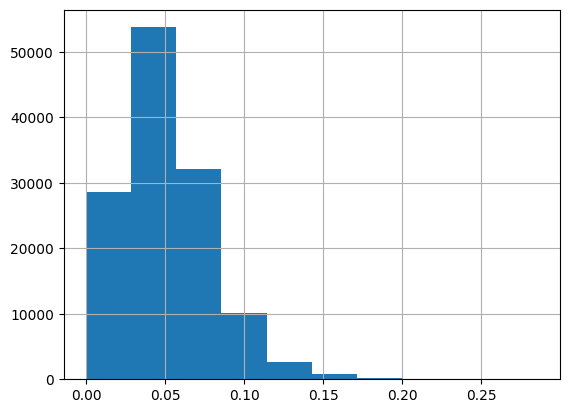

Model has 9510028 parameters
10 | 95/481 | 19.751% |  Train Loss: 0.07 | Test Loss: 0.02 | Memory: 00

UNet(
  (input): Sequential(
    (0): Linear(in_features=1, out_features=24, bias=True)
    (1): ReLU()
  )
  (ups): ModuleList(
    (0): Up(
      (conv): ConvBlock(
        (module): Sequential(
          (0): Conv2d(96, 24, kernel_size=(3, 3), stride=(1, 1), padding=same)
          (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=same)
          (4): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (5): ReLU()
          (6): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=same)
          (7): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (8): ReLU()
          (9): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=same)
          (10): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (11): ReLU()
        )
      )

In [6]:
trainModel(config, UNet, FontData)